# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [176]:
%pip install iso3166

Note: you may need to restart the kernel to use updated packages.


### Upgrade Plotly

Run the cell below if you are working with Google Colab.

In [177]:
%pip install --upgrade plotly

### Import Statements

In [178]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# These might be helpful:
from iso3166 import countries
from datetime import datetime, timedelta
from collections import Counter

### Notebook Presentation

In [179]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [180]:
df_data = pd.read_csv('mission_launches.csv')

# Preliminary Data Exploration

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [181]:
print(f'df_data has {df_data.shape[0]} rows and {df_data.shape[1]} columns')

df_data has 4324 rows and 9 columns


In [182]:
# column names
list(df_data.columns)

['Unnamed: 0.1',
 'Unnamed: 0',
 'Organisation',
 'Location',
 'Date',
 'Detail',
 'Rocket_Status',
 'Price',
 'Mission_Status']

## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [183]:
df_data = df_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [184]:
# dropping duplicated
df_data = df_data.drop_duplicates()


In [185]:
# deleting commas
df_data.Price = df_data.Price.map(lambda x: x.replace(',', '') if type(x) == str else x)
# converting to float
df_data.Price = df_data.Price.astype(float)
# converting datetime
df_data.Date = pd.to_datetime(df_data.Date, utc=True)

In [186]:
df_price = df_data.dropna() # creating separate df for Price, because too many data is missing

## Descriptive Statistics

In [187]:
df_price['Price'].describe()

count     963.00
mean      153.92
std       288.57
min         5.30
25%        40.00
50%        62.00
75%       164.00
max     5,000.00
Name: Price, dtype: float64

# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [188]:
launch_per_organisation = pd.DataFrame(df_data['Organisation'].value_counts())

<Axes: ylabel='count'>

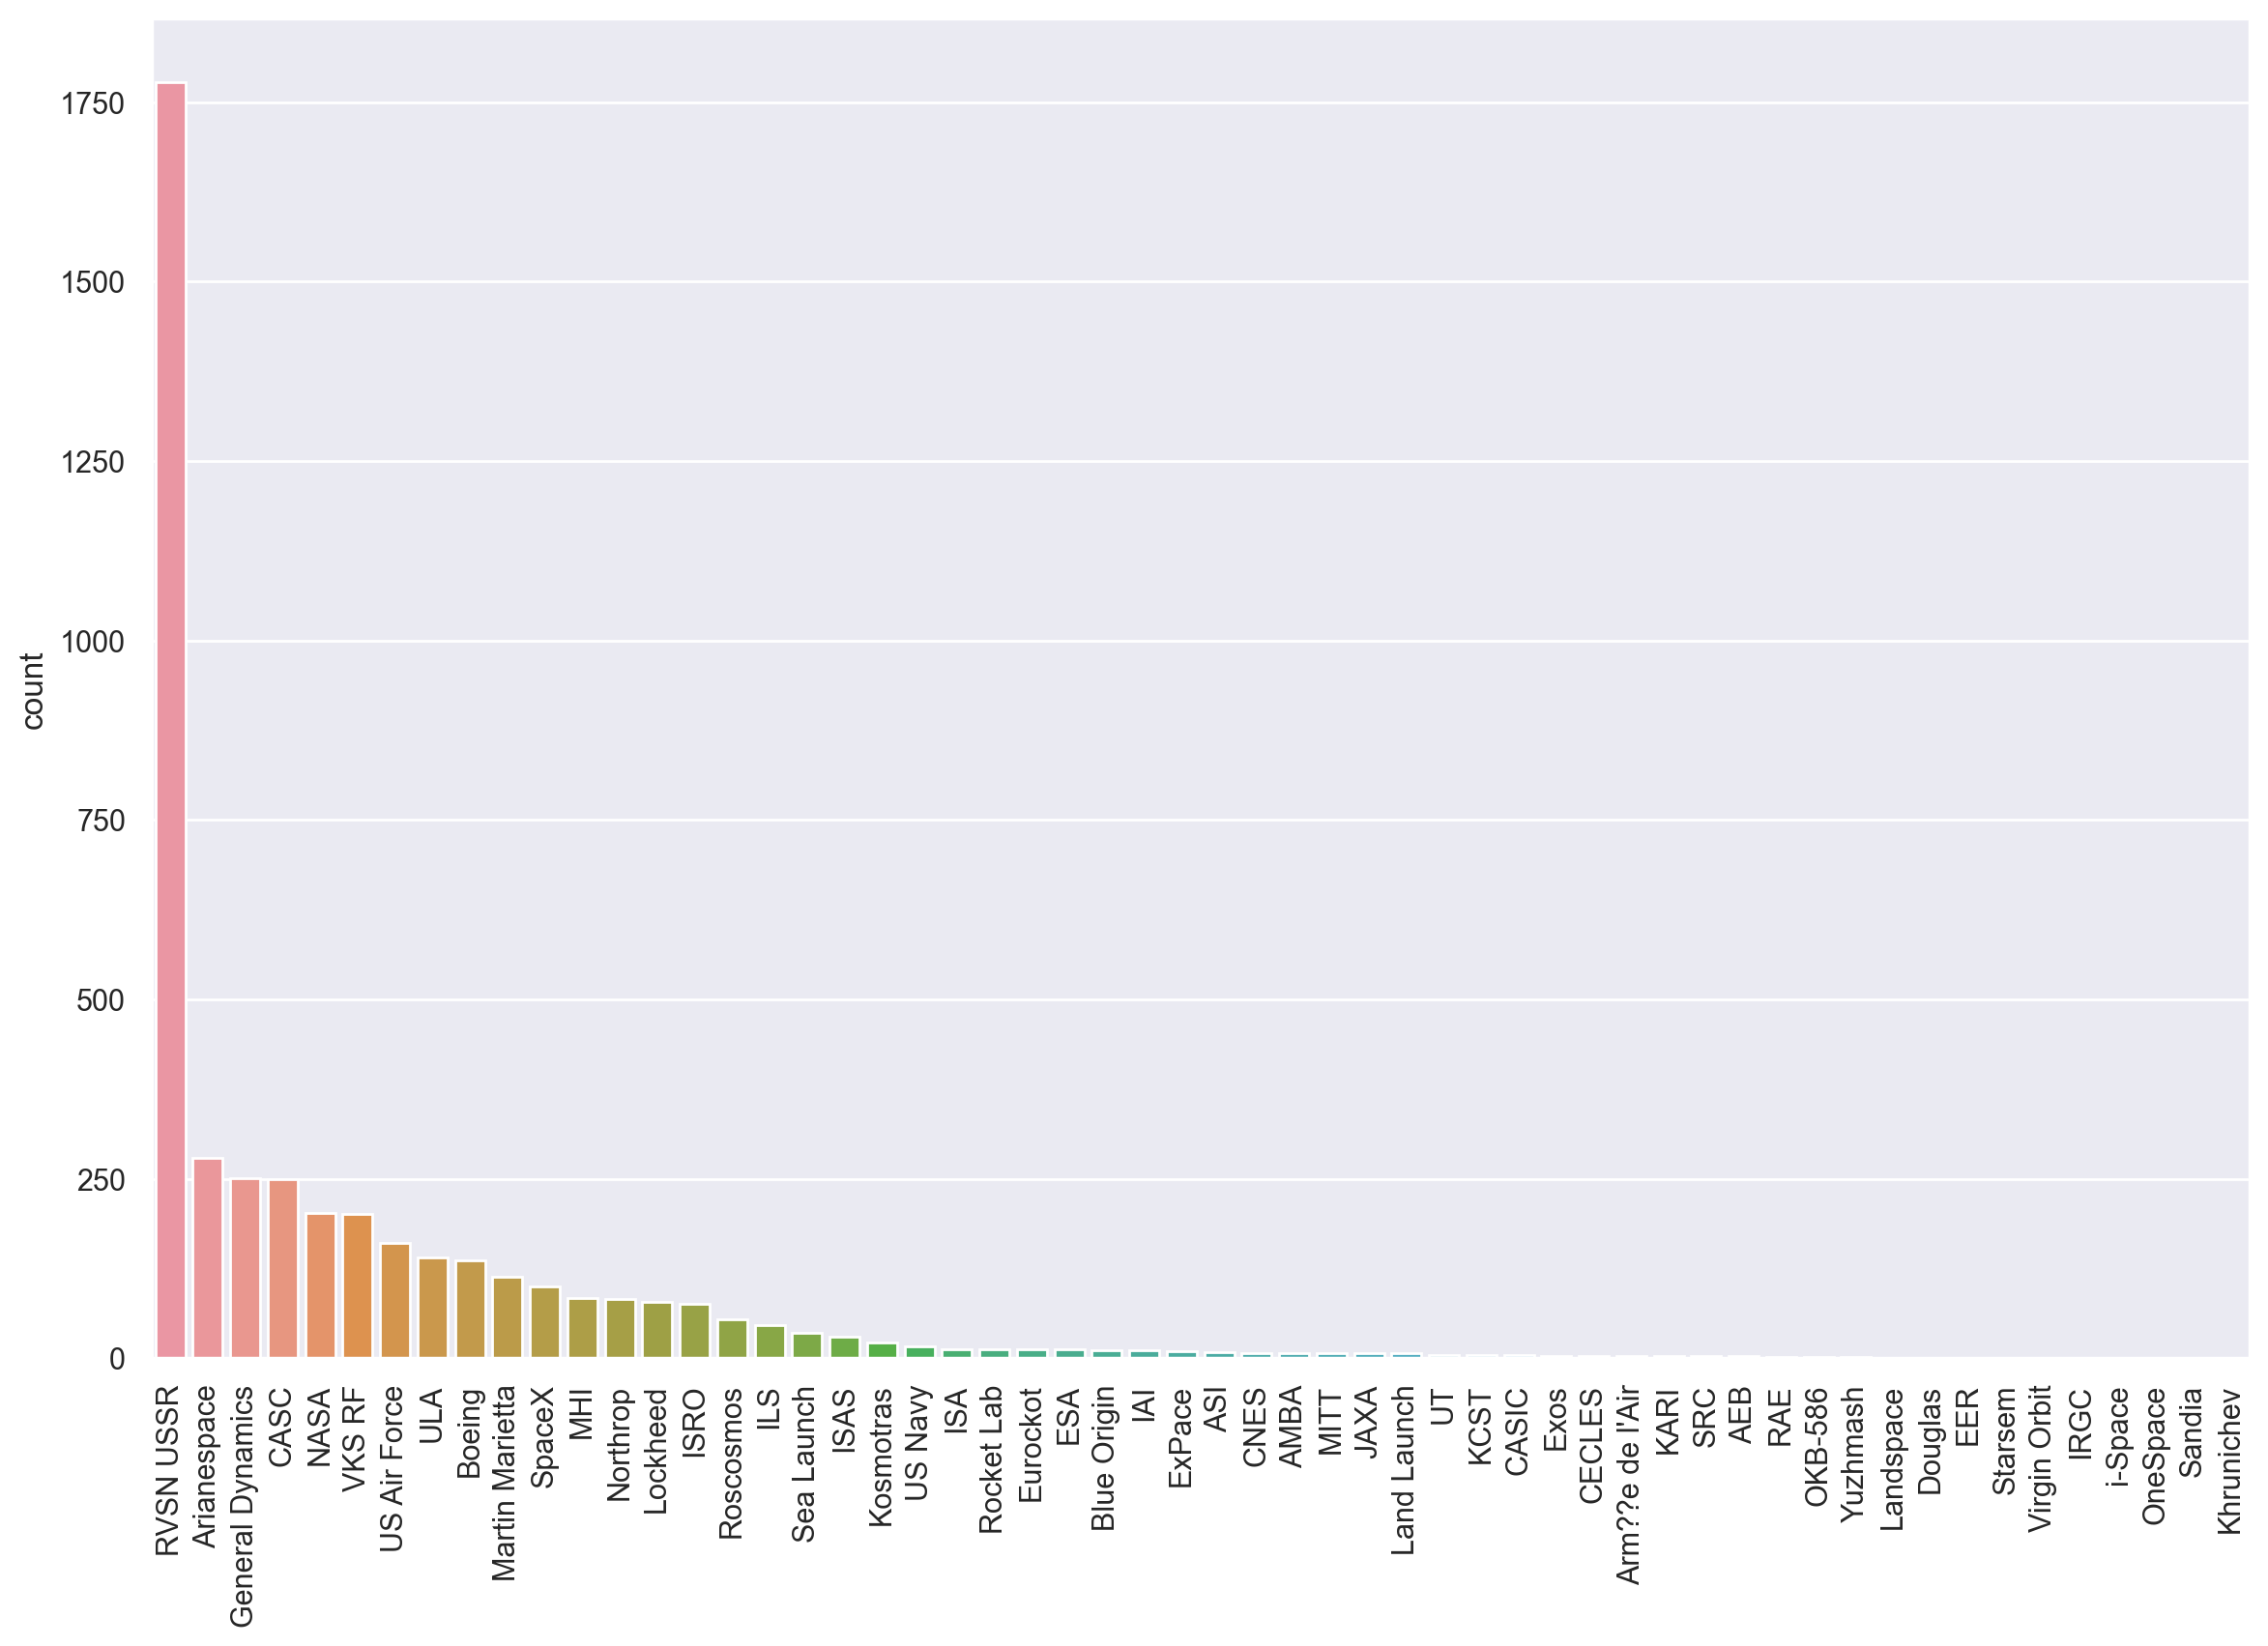

In [189]:
launch_per_organisation = launch_per_organisation.rename(columns={'Organisation': 'count'})
plt.figure(figsize=(14, 9), dpi=200)
plt.xticks(rotation=90)
sns.barplot(data= launch_per_organisation, x=launch_per_organisation.index, y='count')

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [190]:
active = df_data[df_data['Rocket_Status'] == 'StatusActive'].shape[0]
retired = df_data[df_data['Rocket_Status'] == 'StatusRetired'].shape[0]
print(f'Active to retired percent - {(active / retired * 100):.3}%')


Active to retired percent - 22.3%


# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [191]:
success_num = df_data['Mission_Status'].value_counts().loc['Success']
failure_num = df_data['Mission_Status'].value_counts().loc['Failure']
print(f'{success_num} mission were successful, {failure_num} failed')

3878 mission were successful, 339 failed


# How Expensive are the Launches? 

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values). 

In [192]:
sns.set_theme()
outlier_fig = px.histogram(df_price, 'Price', title='Expense with Outlier')
outlier_fig.show()
# without that outlier
clear_fig = px.histogram(df_price[df_price['Price'] < 2000], 'Price', title='Expense without Outlier')
clear_fig.show()

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [193]:
replace_dict = {'Russia': 'Russian Federation',
                        'New Mexico': 'USA',
                        'Yellow Sea': 'China',
                        'Shahrud Missile Test Site': 'Iran, Islamic Republic of',
                        'Iran': 'Iran, Islamic Republic of',
                        'Pacific Missile Range Facility': 'USA',
                        'Barents Sea': 'Russian Federation',
                        'Gran Canaria': 'USA',
                        'North Korea': "Korea, Democratic People's Republic of",
                        'Pacific Ocean': 'USA', 
                        'South Korea': 'Korea, Republic of'}

states = df_data['Location'].map(lambda x: x.split(',')[-1].strip())
states = states.replace(replace_dict)
df_data['iso_alpha'] = [countries.get(state).alpha3 for state in states]

In [194]:
launch_by_country = df_data['iso_alpha'].value_counts()

In [195]:
chropleth_map = px.choropleth(launch_by_country, locations=launch_by_country.index,
                              color=launch_by_country.values,
                             labels={'color': 'Launches',
                                    'index': 'Country'})

# I don't know what's with Crimea...
chropleth_map.show()

# Use a Choropleth Map to Show the Number of Failures by Country


In [196]:
def count_failures(v):
    failures = Counter(v.values)['Failure']
    return failures

failures_df = df_data.groupby(states).agg({'Mission_Status': count_failures}).rename(columns=
                                                                                     {'Mission_Status':'count'})
failures_df = failures_df.reset_index()
failures_df['iso_alpha'] = [countries.get(state).alpha3 for state in failures_df['Location']]
fig = px.choropleth(failures_df, locations='iso_alpha', color='count',
              labels={'count': 'Failures'},
              title='Number of Failures per Country', 
              hover_data={'Location': True, 'count': True, 'iso_alpha': False})
fig.show()


# Create a Plotly Sunburst Chart of the countries, organisations, and mission status. 

In [197]:
df_sunburst = pd.DataFrame({
    'country': [location.split()[-1].strip() for location in df_data['Location']],
    'organisation': df_data['Organisation'],
    'mission_status': df_data['Mission_Status']
})

In [198]:
sun = px.sunburst(df_sunburst, path=['country', 'organisation', 'mission_status'])
sun.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [199]:
money_spent = df_price.groupby('Organisation')['Price'].sum().sort_values(ascending=False)

In [200]:
fig = px.bar(money_spent, money_spent.index, money_spent.values, labels={'y': 'Million USD'},
       title='Total Amount of Money Spent by Organisation')
fig.show()

# Analyse the Amount of Money Spent by Organisation per Launch

In [201]:
mean_spendings = df_price.groupby('Organisation')['Price'].mean()

In [202]:
fig = px.bar(mean_spendings, mean_spendings.index, mean_spendings.values,
             labels={'y': 'Million USD'}, title='Amount of Money Spent by Organisaiton per Launch')
fig.show()

# Chart the Number of Launches per Year

In [203]:
launch_per_year = df_data['Date'].dt.year.value_counts().sort_index()

In [204]:
fig = px.bar(launch_per_year, launch_per_year.index, launch_per_year.values, 
       labels={'index': 'Year', 'y': 'Count'}, title='Number of Launches per Year')
fig.show()

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [205]:
import calendar

month_popularity = df_data['Date'].dt.month.value_counts().sort_index()
month_popularity.index = [calendar.month_name[num] for num in month_popularity.index]

In [206]:
# So December is the most popular and January is the least. It might be (and I bet it is) because of taxes
fig = px.bar(month_popularity, month_popularity.index, month_popularity.values,
            labels={'index': 'Month', 'y': 'Launches'})
fig.show()

# How has the Launch Price varied Over Time? 

Create a line chart that shows the average price of rocket launches over time. 

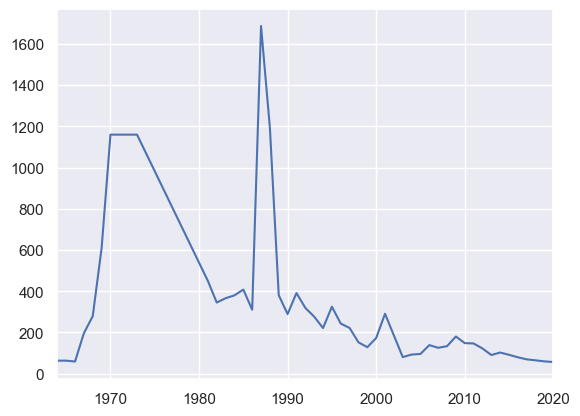

In [207]:
mean_price = df_price.groupby(df_price['Date'].dt.year)['Price'].mean()
simp_mean = plt.plot(mean_price)
plt.xlim(min(df_price['Date'].dt.year), max(df_price['Date'].dt.year))
plt.show()

# Chart the Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

In [208]:
top_ten = df_data['Organisation'].value_counts().sort_values(ascending=False).head(10)

In [209]:
df_top = df_data[df_data['Organisation'].isin(top_ten.index)]

plot_df = df_top.groupby([df_top['Date'].dt.year, 'Organisation']).count()['Location']
px.line(plot_df, x=plot_df.index.map(lambda x: x[0]), y=plot_df.values, color=plot_df.index.map(lambda x: x[1]),
        labels={'x': 'Year', 'y': 'Launches'},
        title='Launches per Organisation Yearly')




# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

In [210]:
cold_war = df_data[df_data.Date.dt.year <= 1991]

## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches. 

In [211]:
cw_launches = cold_war['Location'].map(lambda x: x.split(',')[-1].strip()).value_counts()
cw_launches['USSR'] = cw_launches['Russia'] + cw_launches['Kazakhstan']
cw_launches = cw_launches.drop(['Russia','Kazakhstan'])

fig = px.pie(cw_launches, cw_launches.index, cw_launches.values)
fig.show()

In [212]:
power_launches = cw_launches[(cw_launches.index =='USA') | (cw_launches.index == 'USSR')]
power_launches = pd.DataFrame(power_launches).reset_index().rename(columns={
    'index': 'country',
    'Location': 'launches'
})

In [213]:
fig = px.pie(power_launches, 'country', 'launches', 
      labels={'country': "Country",
              'launches': 'Launches'})
fig.show()

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

In [214]:
def count_failure(v):
#     number of failures in the year
    failures = Counter(v.values)['Failure']
    return failures / len(v.values)

# getting percentage of failures per year
df_failure = df_data.groupby(df_data['Date'].dt.year).agg({'Mission_Status': count_failure})
df_failure = df_failure.rename(columns={'Mission_Status': 'pct_failure'})

In [215]:
fig = px.bar(df_failure, df_failure.index, 'pct_failure', title='Percentage of Failures per Year',
             labels={'pct_failure': 'Percentage of Failures',
                     'Date': 'Year'})
fig.show()

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches? 

In [216]:
def get_leader(v):
    year = df_data.loc[v.index]['Date'].dt.year
    countries = [location.split(',')[-1].strip() for location in v.values]
    
    launches_per_country = Counter(countries)
    for country in ['Russia', 'Kazakhstan']:
        if launches_per_country.get(country) is None:
            launches_per_country[country] = 0
            
    if (year <= 1991).any():
        launches_per_country['USSR'] = launches_per_country['Russia'] + launches_per_country['Kazakhstan']
#         I need to change this
        launches_per_country = {key: value for key, value in launches_per_country.items() if key not in ['Russia', 'Kazakhstan']}
    
    answer = max(launches_per_country, key=launches_per_country.get)
    return answer
            
    
leaders = df_data.groupby(df_data['Date'].dt.year).agg({'Location': get_leader})

In [217]:
leaders

,Location
Date,
1957,USSR
1958,USA
1959,USA
1960,USA
1961,USA
...,...
2016,USA
2017,USA
2018,China
